# Import Library

In [1]:
!pip install numpy==1.23.5 scipy==1.10.1 gensim==4.3.1 tensorflow==2.12.0 scikit-learn textblob sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.0 MB/s eta 0:00:00
 

In [1]:
# Umum
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Machine Learning & Evaluasi
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

# Word Embedding
from gensim.models import Word2Vec

# Deep Learning - CNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Submission_AnalisisSentimen/Submission_AnalisisSentimen/scrapping_jumbo.csv')
df.head()

,Komentar,Jumlah Like
0,Halo p,0
1,Halo p,0
2,si atta ngeselin woi oh ya btw grafik nya bag...,0
3,aku sudah nonton pas hari selasa😅😅😅 sedih bang...,0
4,Akhirnya ada animasi tanpa agenda LGBT,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17258 entries, 0 to 17257
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Komentar     17258 non-null  object
 1   Jumlah Like  17258 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 269.8+ KB


In [5]:
print(df.isnull().sum())

Komentar       0
Jumlah Like    0
dtype: int64


# Preprocessing

In [6]:
# Ganti nama kolom kalau perlu
df.columns = ['komentar', 'jumlah_like']

In [7]:
# 1. Hapus komentar yang spam, tidak relevan, atau mengandung link YouTube
def is_spam(text):
    spam_keywords = ["ALEXIS17", "𝐿𝟩𝟳𝟩", "𝐴𝘌RО𝟾𝟪", "𝐒𝐆𝐈𝟖𝟖", "𝗪𝗘𝗧𝗢𝗡𝟴𝟴", "𝘈G𝑈𝘚𝙏O𝑇𝙊"]
    return any(spam.lower() in text.lower() for spam in spam_keywords)

def is_irrelevant(text):
    keywords = ['norma', 'qodrat', 'minecraft']
    return any(keyword in text.lower() for keyword in keywords)

def contains_youtube_link(text):
    return 'youtu.be' in text or 'youtube.com' in text

df = df[
    ~(df['komentar'].apply(is_spam)) &
    ~(df['komentar'].apply(is_irrelevant)) &
    ~(df['komentar'].apply(contains_youtube_link))
].reset_index(drop=True)

# 2. Hapus nilai kosong
df = df.dropna(subset=['komentar'])

# 3️. Hapus duplikasi berdasarkan ‘komentar’
df = df.drop_duplicates(subset=['komentar'])

# 4️. Bersihkan teks (hapus link, tanda baca, spasi berlebih)
def cleaningText(text):
    text = re.sub(r"http\S+", "", text)   # Hapus URL
    text = re.sub(r"[^\w\s]", "", text)   # Hapus tanda baca
    text = re.sub(r"\s+", " ", text)      # Hapus spasi berlebih
    text = text.replace('<br>', ' ')      # Ganti <br> dengan spasi
    text = text.strip()                   # Hapus spasi di awal/akhir
    return text

df['text_cleaned'] = df['komentar'].apply(cleaningText)

# 5️. Konversi teks ke huruf kecil
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: x.lower())

# 6️. Perbaikan Kata (Typo + Slangwords + Kata Tidak Baku)
slangwords = {
    "byk": "banyak", "btw": "ngomong-ngomong", "gak": "tidak", "indpnesia": "indonesia",
    "ak": "aku", "trus": "terus", "ama": "sama", "yg": "yang", "pikir": "fikir", "dgn": "dengan",
    "udh": "sudah", "ga": "tidak", "aja": "saja", "pilem": "film", "yh": "ya", "gk": "tidak",
    "kyk": "seperti", "ngomong": "berbicara", "smakin": "semakin", "smoga": "semoga", "gue": "aku",
    "bgt": "sekali", "mnurut": "menurut", "jaman": "zaman", "dlu": "dahulu", "gara": "karena",
    "gw": "aku", "sekedar": "sekadar", "filem": "film", "kayak": "seperti", "gua": "aku", "ato": "atau",
    "emank": "memang", "bgus": "bagus", "dr": "dari", "pd": "pada", "liyat": "lihat", "cpt": "cepat",
    "tp": "tetapi", "kwalitas": "kualitas", "ku": "aku", "sosmed": "sosial media", "indo": "indonesia",
    "kek": "seperti", "bnyak": "banyak", "jgn": "jangan", "kpd": "kepada", "lbh": "lebih",
    "yutub": "youtube", "yah": "ya", "gela": "gila", "kren": "keren", "dah": "sudah", "gx": "tidak",
    "cma": "hanya", "smp": "sampai", "bgs": "bagus", "kaga": "tidak", "krya": "karya",
    "dgr": "dengar", "mngkin": "mungkin", "krn": "karena", "hrs": "harus", "wlw": "walau",
    "usah": "perlu", "kaya": "seperti", "njay": "anjing", "hbs": "habis", "aq": "aku", "sm": "sama",
    "jg": "juga", "detil": "detail", "g": "tidak", "sy": "saya", "trnyta": "ternyata", "bs": "bisa",
    "udah": "sudah", "ampe": "sampai", "lg": "lagi", "tdk": "tidak", "utk": "untuk", "sllu": "selalu",
    "nnton": "nonton", "klu": "jika", "bakal": "akan", "tdi": "tadi", "mlam": "malam", "sdh": "sudah",
    "grapis": "grafis", "skrg": "sekarang", "kl": "jika", "emang": "memang", "mmng": "memang",
    "emng": "memang", "gerafik": "grafik", "pingin": "ingin", "moga": "semoga", "blm": "belum",
    "pengen": "ingin", "jir": "anjing", "knp": "kenapa", "bkin": "membuat", "sbg": "sebagai", "mo": "mau"
}

def fix_slangwords(text):
    words = text.split()
    return ' '.join([slangwords[word] if word in slangwords else word for word in words])

df['text_cleaned'] = df['text_cleaned'].apply(fix_slangwords)

# 7️. Tokenisasi (pecah teks menjadi kata-kata) dan hapus stopwords
def tokenizingText(text):
    return text.split()

def tokenizingText(text):
    return text.split()

factory = StopWordRemoverFactory()
stopwords_indo = set(factory.get_stop_words())

def filteringText(tokens):
    return [word for word in tokens if word not in stopwords_indo]

df['text_tokenized'] = df['text_cleaned'].apply(tokenizingText)
df['text_stopwords_removed'] = df['text_tokenized'].apply(filteringText)

# 8. Gabungkan kembali token menjadi kalimat bersih
def toSentence(tokens):
    return ' '.join(tokens)

df['text_final'] = df['text_stopwords_removed'].apply(toSentence)

# 9. Cek hasil akhir
df[['komentar', 'text_final']].head()

,komentar,text_final
0,Halo p,halo p
2,si atta ngeselin woi oh ya btw grafik nya bag...,si atta ngeselin woi ngomong-ngomong grafik ny...
3,aku sudah nonton pas hari selasa😅😅😅 sedih bang...,aku nonton pas hari selasa sedih banget film nya
4,Akhirnya ada animasi tanpa agenda LGBT,akhirnya animasi agenda lgbt
5,Sedih banget kartu ya ❤🎉😊,sedih banget kartu


In [8]:
# Cek jumlah data setelah preprocessing
print("Jumlah data setelah preprocessing:", df.shape[0])

Jumlah data setelah preprocessing: 15278


# Pelabelan

In [9]:
# Fungsi untuk menentukan label sentimen (0: negatif, 1: netral, 2: positif)
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0.1:
        return 2  # positif
    elif polarity < -0.1:
        return 0  # negatif
    else:
        return 1  # netral

# Terapkan fungsi ke data bersih
df['label'] = df['text_final'].apply(get_sentiment)

# Cek hasil akhir
df[['text_final', 'label']].head()

,text_final,label
0,halo p,1
2,si atta ngeselin woi ngomong-ngomong grafik ny...,1
3,aku nonton pas hari selasa sedih banget film nya,1
4,akhirnya animasi agenda lgbt,1
5,sedih banget kartu,1


In [10]:
# Cek jumlah data setelah pelabelan
print("Jumlah data setelah pelabelan:", df.shape[0])

Jumlah data setelah pelabelan: 15278


In [11]:
# Simpan hasil bersih ke CSV
df.to_csv('data_label_clean.csv', index=False)

# Cek apakah file berhasil disimpan
print("File CSV 'data_label_clean.csv' telah berhasil dibuat!")

File CSV 'data_label_clean.csv' telah berhasil dibuat!


In [12]:
# Baca file CSV
df = pd.read_csv('data_label_clean.csv')

# Hitung jumlah data per label
label_counts = df['label'].value_counts()

# Definisikan nama label
label_mapping = { 0: "Negatif", 1: "Netral", 2: "Positif" }

# Cek hasil
for label, count in label_counts.items(): print(f"{label_mapping[label]} ({label}): {count}")

Netral (1): 14268
Positif (2): 895
Negatif (0): 115


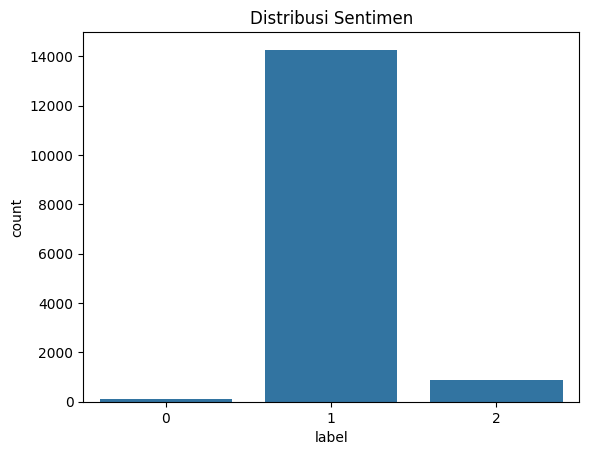

In [25]:
sns.countplot(x=df['label'])
plt.title("Distribusi Sentimen")
plt.show()

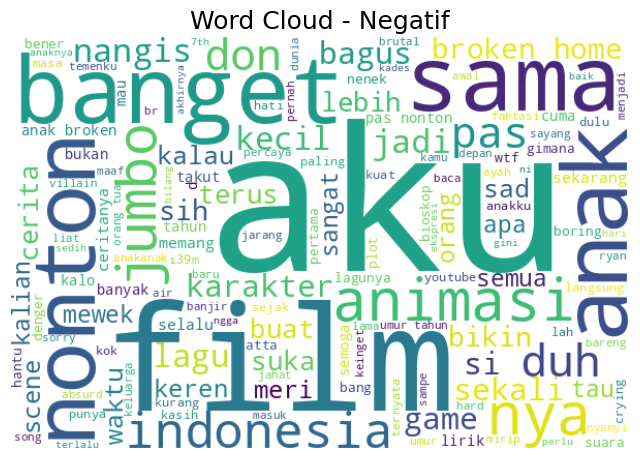

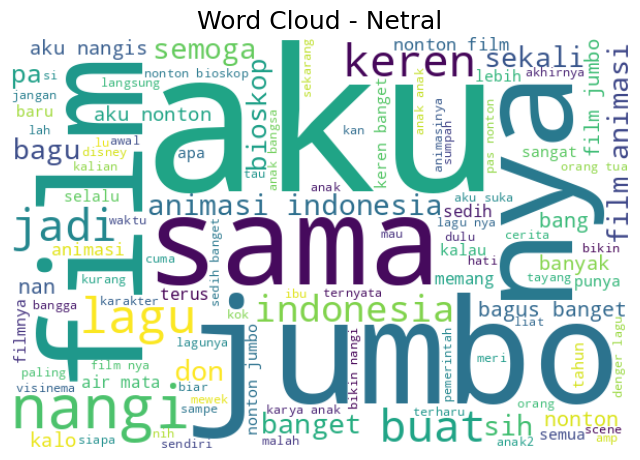

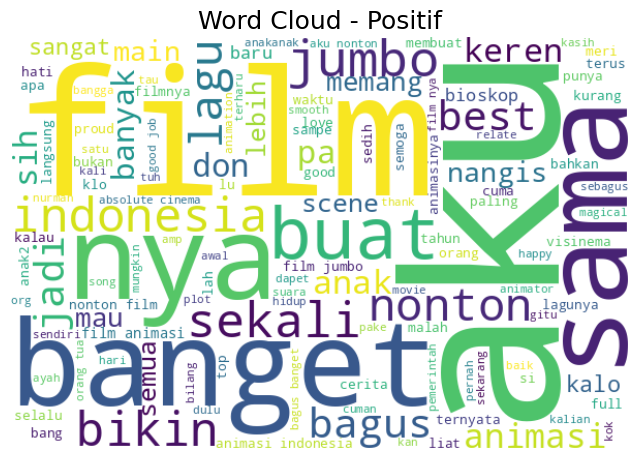

In [13]:
# Loop untuk membuat WordCloud berdasarkan masing-masing label
for label in label_mapping:
    # Convert all elements in 'text_final' to strings before joining
    list_words = ' '.join(
        str(' '.join(tweet) if isinstance(tweet, list) else tweet)  # Convert to string here
        for tweet in df[df['label'] == label]['text_final']
    )

    # Buat objek WordCloud
    wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

    # Tampilkan WordCloud
    plt.figure(figsize=(8, 6))
    plt.title(f"Word Cloud - {label_mapping[label]}", fontsize=18)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

# Ekstraksi Fitur

### Menggunakan TF-IDF


In [14]:
# Pastikan tidak ada NaN sebelum ekstraksi
df['text_final'] = df['text_final'].fillna('')

# Buat objek TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Ambil 5000 fitur paling penting

# Transformasikan teks menjadi vektor numerik
X_tfidf = tfidf_vectorizer.fit_transform(df['text_final'])

# Cek dimensi hasil ekstraksi
print("Dimensi fitur TF-IDF:", X_tfidf.shape)  # (Jumlah sampel, Jumlah fitur)

Dimensi fitur TF-IDF: (15278, 5000)


- 15278 → Jumlah baris dalam dataset (jumlah sampel teks)
- 5000 → Jumlah fitur yang diekstrak dari teks (kata-kata penting berdasarkan TF-IDF)
---
Artinya, setiap teks diwakili oleh 5000 angka, menunjukkan seberapa penting kata-kata dalam teks



### Menggunakan Word2Vec

In [15]:
# Tokenisasi teks supaya bisa digunakan di Word2Vec
sentences = df['text_final'].apply(lambda x: x.split())

# Latih model Word2Vec
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Representasikan teks dengan Word2Vec
def get_vector(text):
    words = text.split()
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return sum(vectors) / len(vectors) if vectors else [0]*100  # Jika kosong, beri vektor nol

X_word2vec = df['text_final'].apply(get_vector)

# Cek dimensi hasil ekstraksi
print("Dimensi fitur Word2Vec:", len(X_word2vec))

Dimensi fitur Word2Vec: 15278


In [16]:
# Pastikan setiap vektor memiliki dimensi yang sama (100)
X_word2vec_matrix = np.array(X_word2vec.tolist())  # Convert list ke array numpy

# Cek dimensi setelah konversi
print("Dimensi fitur Word2Vec setelah konversi:", X_word2vec_matrix.shape)  #

Dimensi fitur Word2Vec setelah konversi: (15278, 100)


- 15278 → Jumlah baris dalam dataset (jumlah sampel teks)
- 100 → Jumlah dimensi vektor Word2Vec
---

# Pembagian Data (Train-Test split)

In [17]:
# Pisahkan data TF-IDF untuk training & testing (80/20 split)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, df['label'], test_size=0.2, random_state=42
)

# Pisahkan data Word2Vec untuk training & testing (80/20 split)
X_train_w2v, X_test_w2v, _, _ = train_test_split(
    X_word2vec_matrix, df['label'], test_size=0.2, random_state=42
)

# Cek jumlah data training & testing
print("Jumlah data training TF-IDF:", X_train_tfidf.shape[0])
print("Jumlah data testing TF-IDF:", X_test_tfidf.shape[0])
print("Jumlah data training Word2Vec:", X_train_w2v.shape[0])
print("Jumlah data testing Word2Vec:", X_test_w2v.shape[0])

Jumlah data training TF-IDF: 12222
Jumlah data testing TF-IDF: 3056
Jumlah data training Word2Vec: 12222
Jumlah data testing Word2Vec: 3056


# Pelatihan Model

### Model SVM (TF-IDF)

In [18]:
# Latih model SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Prediksi
y_pred_train_svm = svm_model.predict(X_train_tfidf)
y_pred_test_svm = svm_model.predict(X_test_tfidf)

# Evaluasi akurasi
accuracy_train_svm = accuracy_score(y_train, y_pred_train_svm)
accuracy_test_svm = accuracy_score(y_test, y_pred_test_svm)

print('SVM - Akurasi Training:', accuracy_train_svm)
print('SVM - Akurasi Testing:', accuracy_test_svm)

SVM - Akurasi Training: 0.9825724104074619
SVM - Akurasi Testing: 0.9712041884816754


### Model Naive Bayes (TF-IDF)

In [19]:
# Latih model Naive Bayes
nb_model = BernoulliNB()
nb_model.fit(X_train_tfidf.toarray(), y_train)

# Prediksi
y_pred_train_nb = nb_model.predict(X_train_tfidf.toarray())
y_pred_test_nb = nb_model.predict(X_test_tfidf.toarray())

# Evaluasi akurasi
accuracy_train_nb = accuracy_score(y_train, y_pred_train_nb)
accuracy_test_nb = accuracy_score(y_test, y_pred_test_nb)

print('Naive Bayes - Akurasi Training:', accuracy_train_nb)
print('Naive Bayes - Akurasi Testing:', accuracy_test_nb)

Naive Bayes - Akurasi Training: 0.9095892652593683
Naive Bayes - Akurasi Testing: 0.9031413612565445


### Model Random Forest (Word2Vec)

In [20]:
# Latih model RF dengan Word2Vec
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_w2v.tolist(), y_train)

# Prediksi
y_pred_train_rf = rf_model.predict(X_train_w2v.tolist())
y_pred_test_rf = rf_model.predict(X_test_w2v.tolist())

# Evaluasi akurasi
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

print('Random Forest - Akurasi Training:', accuracy_train_rf)
print('Random Forest - Akurasi Testing:', accuracy_test_rf)

Random Forest - Akurasi Training: 0.9997545409916544
Random Forest - Akurasi Testing: 0.9410994764397905


**Kesimpulan dari 3 model yang sudah diuji:**

**Naive Bayes**  
   - Akurasi Testing: 90.31% → Performanya cukup baik sebagai baseline
   - Cepat & ringan, cocok untuk data teks sederhana
   - Tapi masih kalah dibanding SVM, karena Naive Bayes mengasumsikan bahwa fitur independen, padahal dalam bahasa alami sering kali kata-kata punya hubungan kuat

**SVM (TF-IDF)**
   - Akurasi Testing: 97.12% → Model paling kuat dari yang diuji
   - Bagus dalam menangkap pola kompleks, terutama karena TF-IDF memberi representasi fitur yang jelas
   - Ideal untuk analisis sentimen berbasis teks, karena bisa memisahkan kelas dengan margin yang optimal

**Random Forest (Word2Vec)**  
   - Akurasi Testing: 94.01% → Lebih baik daripada Naive Bayes, tapi masih di bawah SVM
   - Training mencapai 99.97%, jauh lebih tinggi daripada testing, yang bisa jadi indikasi overfitting
   - RF bekerja dengan fitur Word2Vec, tapi karena pendekatan RF berbasis pohon keputusan, mungkin kurang maksimal dalam menangkap hubungan antar kata seperti SVM.

# Algoritma Deep Learning

In [21]:
# Persiapan data untuk CNN
X_train_w2v_reshaped = X_train_w2v.reshape(-1, 100, 1)
X_test_w2v_reshaped = X_test_w2v.reshape(-1, 100, 1)

In [22]:
# Membuat model CNN
model_cnn = Sequential([
    Conv1D(128, 3, activation='relu', input_shape=(100, 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 kelas sentimen (positif, netral, negatif)
])

# Compile model
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Latih model
model_cnn.fit(X_train_w2v_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_w2v_reshaped, y_test))

# Evaluasi
loss, accuracy = model_cnn.evaluate(X_test_w2v_reshaped, y_test)
print("CNN - Akurasi Testing:", accuracy)

Epoch 1/10
382/382 [==============================] - 4s 7ms/step - loss: 0.3139 - accuracy: 0.9311 - val_loss: 0.2548 - val_accuracy: 0.9375
Epoch 2/10
382/382 [==============================] - 4s 11ms/step - loss: 0.2692 - accuracy: 0.9330 - val_loss: 0.2499 - val_accuracy: 0.9375
Epoch 3/10
382/382 [==============================] - 3s 7ms/step - loss: 0.2632 - accuracy: 0.9330 - val_loss: 0.2468 - val_accuracy: 0.9375
Epoch 4/10
382/382 [==============================] - 3s 7ms/step - loss: 0.2591 - accuracy: 0.9330 - val_loss: 0.2433 - val_accuracy: 0.9375
Epoch 5/10
382/382 [==============================] - 3s 7ms/step - loss: 0.2578 - accuracy: 0.9330 - val_loss: 0.2458 - val_accuracy: 0.9375
Epoch 6/10
382/382 [==============================] - 3s 8ms/step - loss: 0.2563 - accuracy: 0.9330 - val_loss: 0.2418 - val_accuracy: 0.9375
Epoch 7/10
382/382 [==============================] - 4s 9ms/step - loss: 0.2556 - accuracy: 0.9330 - val_loss: 0.2441 - val_accuracy: 0.9375
Epoch

**Kesimpulan Deep Learning menggunakan CNN:**
- Akurasi Training: 93.30% → Model belajar dengan baik dari dataset
- Akurasi Testing: 93.75% → Model tetap kuat saat diuji dengan data baru
- Loss terus menurun setiap epoch → Ini indikasi bahwa model berhasil belajar tanpa mengalami penurunan performa
- CNN bisa bersaing dengan RF dalam akurasi, tapi lebih stabil dibanding RF yang cenderung overfit
- SVM tetap memiliki performa terbaik sejauh ini dengan akurasi tertinggi 97.12%

# Inference

In [24]:
# Membuat model prediksi
def predict_sentiment(text, model, w2v_model):
    words = text.split()
    vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]

    if len(vectors) == 0:
        return "Sentimen tidak dapat diprediksi (kata tidak dikenali)"

    # Ambil rata-rata vektor kata
    text_vector = np.mean(vectors, axis=0).reshape(1, 100, 1)

    # Prediksi
    prediction = model.predict(text_vector)
    label_index = np.argmax(prediction)

    labels = ["Negatif", "Netral", "Positif"]
    return labels[label_index]

# Loop untuk input dari user
while True:
    text_input = input("Masukkan teks untuk dianalisis (ketik 'exit' untuk keluar): ")
    if text_input.lower() == "exit":
        break

    result = predict_sentiment(text_input, model_cnn, w2v_model)
    print("Prediksi Sentimen:", result)

Masukkan teks untuk dianalisis (ketik 'exit' untuk keluar): Animasinya indah banget, keren banget!
1/1 [==============================] - 0s 21ms/step
Prediksi Sentimen: Netral
Masukkan teks untuk dianalisis (ketik 'exit' untuk keluar): Animasinya bagus
1/1 [==============================] - 0s 23ms/step
Prediksi Sentimen: Netral
Masukkan teks untuk dianalisis (ketik 'exit' untuk keluar): Filmnya membosankan, sama sekali tidak menarik
1/1 [==============================] - 0s 31ms/step
Prediksi Sentimen: Netral
Masukkan teks untuk dianalisis (ketik 'exit' untuk keluar): filmnya parah banget bikin kesel
1/1 [==============================] - 0s 43ms/step
Prediksi Sentimen: Netral
Masukkan teks untuk dianalisis (ketik 'exit' untuk keluar): exit
